In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection
License(s): copyright-authors
100% 84.0M/84.0M [00:06<00:00, 16.4MB/s]
100% 84.0M/84.0M [00:06<00:00, 13.2MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
# Load dataset directories
no_tumor_dir = '/content/no'
yes_tumor_dir = '/content/yes'

In [7]:
# Function to load images
#This function, load_images_from_folder, takes a folder path as input, iterates over all files in the folder, reads and resizes each image to 128x128 pixels,
#and returns a list of these processed images. It skips any files that are not valid images.#
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images

In [8]:
# Load images
no_tumor_images = load_images_from_folder(no_tumor_dir )
yes_tumor_images = load_images_from_folder(yes_tumor_dir)

In [9]:
no_tumor_labels = [0] * len(no_tumor_images)
yes_tumor_labels = [1] * len(yes_tumor_images)

In [33]:
X = np.array(no_tumor_images + yes_tumor_images)
y = np.array(no_tumor_labels + yes_tumor_labels)

In [11]:
# Data Preprocessing
#Normalization (X = X / 255.0): Scales image pixel values to the range [0, 1] to improve training performance.
#One-Hot Encoding (y = to_categorical(y, num_classes=2)): Converts class labels into a binary matrix representation, facilitating the neural network’s
#ability to handle multi-class classification.
X = X / 255.0
y = to_categorical(y, num_classes=2)

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

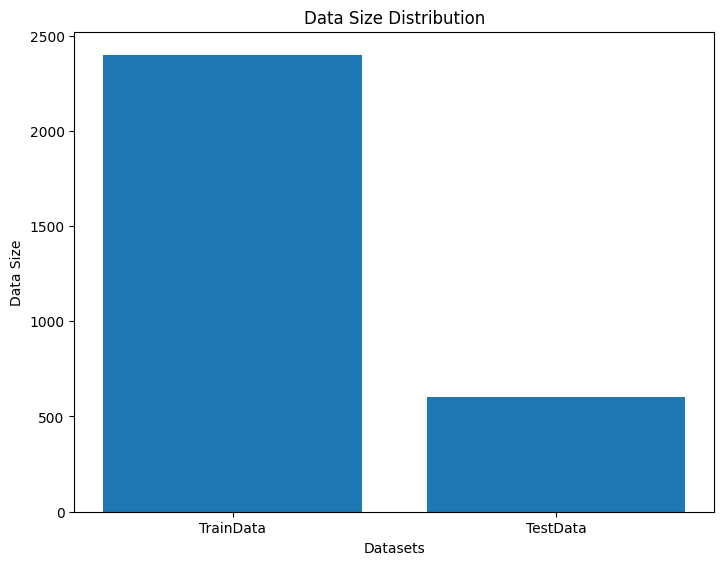

In [41]:

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
langs = ['TrainData', 'TestData']
data = [len(X_train), len(X_test)]

# Adjust bar positions to avoid overlapping
x = range(len(langs))  # Create positions for each bar

ax.bar(x, data)  # Plot bars using positions

# Set labels and title
plt.xticks(x, langs)  # Set x-axis ticks with corresponding labels
plt.xlabel('Datasets')
plt.ylabel('Data Size')
plt.title('Data Size Distribution')

plt.show()


In [13]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [14]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#flatten coverts 2d into 1d  ...dense (2) is used for classification ...dropout is used to avoid overfitting./.

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the last two layers of the base model
for layer in base_model.layers[:-2]:
    layer.trainable = False
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Create a Sequential model and add layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 14731074 (56.19 MB)
Trainable params: 2376194 (9.06 MB)
Non-trainable params: 12354880 (47.13 MB)
_________________________________________________________________


In [23]:
# Model training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
75/75 [==============================] - 28s 251ms/step - loss: 0.5948 - accuracy: 0.6867 - val_loss: 0.3261 - val_accuracy: 0.8733
Epoch 2/25
75/75 [==============================] - 13s 167ms/step - loss: 0.4116 - accuracy: 0.8108 - val_loss: 0.3049 - val_accuracy: 0.8683
Epoch 3/25
75/75 [==============================] - 13s 169ms/step - loss: 0.3318 - accuracy: 0.8587 - val_loss: 0.2004 - val_accuracy: 0.9300
Epoch 4/25
75/75 [==============================] - 13s 172ms/step - loss: 0.3086 - accuracy: 0.8696 - val_loss: 0.1926 - val_accuracy: 0.9300
Epoch 5/25
75/75 [==============================] - 13s 179ms/step - loss: 0.2771 - accuracy: 0.8863 - val_loss: 0.1724 - val_accuracy: 0.9367
Epoch 6/25
75/75 [==============================] - 14s 185ms/step - loss: 0.2424 - accuracy: 0.9013 - val_loss: 0.1692 - val_accuracy: 0.9400
Epoch 7/25
75/75 [==============================] - 14s 181ms/step - loss: 0.2252 - accuracy: 0.9108 - val_loss: 0.1688 - val_accuracy: 0.9400

In [24]:
# Model evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

19/19 [==============================] - 1s 46ms/step


In [25]:
# Classification report and confusion matrix
print("Classification Report:\n", classification_report(y_true, y_pred_classes))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       313
           1       0.93      1.00      0.97       287

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

Confusion Matrix:
 [[293  20]
 [  0 287]]


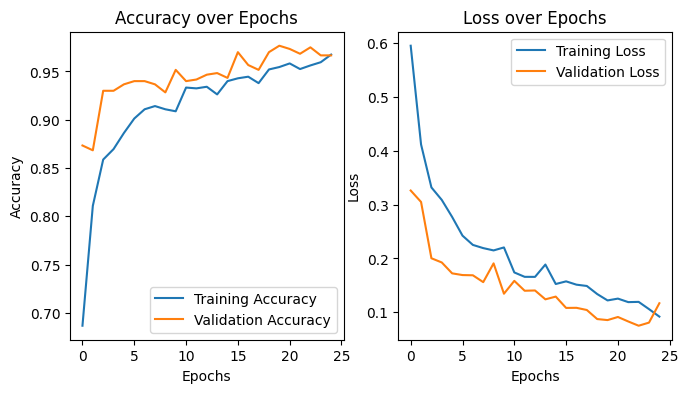

In [26]:
# Plotting training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

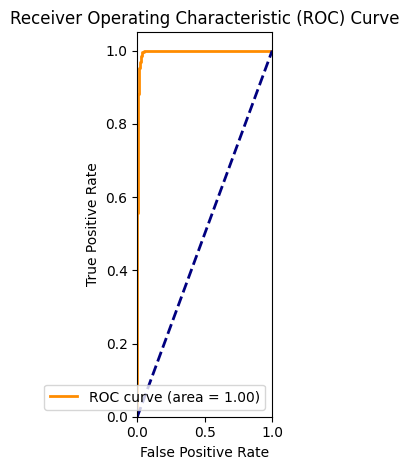

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

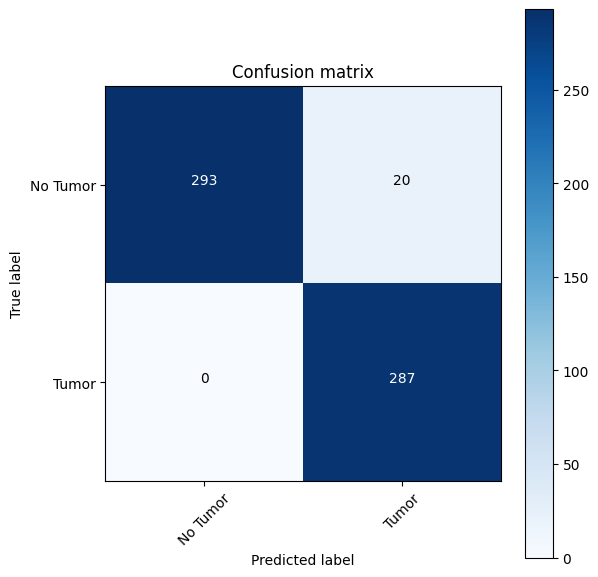

In [28]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(cm, classes=['No Tumor', 'Tumor'])

In [29]:
# prompt: whats the  accracy of the model

# Find the maximum validation accuracy
max_val_accuracy = max(history.history['val_accuracy'])
print("Maximum Validation Accuracy:", max_val_accuracy)


Maximum Validation Accuracy: 0.9766666889190674


In [30]:
# prompt: whats the accuracy of the model

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', accuracy)


Test accuracy: 0.9666666388511658


In [ ]:
#improvements to be done:use validation data..